# GraphSeg and Blocks model
- Learning how to classifiy blocks as relevant
- Using Graphseg or PyMuPDF blocks

Refer to Section 5.1 of report for more details

### Import libraries

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import sys
from collections import defaultdict
import subprocess
import shutil
import tempfile
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt

# Preprocessing
sys.path.append('../DataPreprocessing')
sys.path.append('../DataAnalysis')
from read_into_dicts import DocReader

# Model
import torch
from torch.utils.data import Dataset, random_split, Subset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

# WANDB
import wandb
from tqdm.notebook import tqdm
import random
import string


import yaml
import pickle
import json

2024-05-28 08:26:13.157311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 08:26:14.220797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Config

In [26]:
# Load configuration
with open('configs/config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# GENERAL:
DEBUG = config["general"]["DEBUG"]
MODEL = config["general"]["MODEL"]
DATA_SIZE = config["general"]["DATA_SIZE"]
DOMAIN = config["general"]['DATA_DICT_FILE_PATH']["DOMAIN"]
DATA_DICT_FILE_PATH = config["general"]['DATA_DICT_FILE_PATH'][DOMAIN]
DATA_PATH = config["general"]["DATA_PATH"]
SPLITS_JSON = config["general"]["SPLITS_JSON"]
TRAIN_SIZE = config["general"]["TRAIN_SIZE"]
VAL_SIZE = config["general"]["VAL_SIZE"]
USE_MULTIPROCESSING = config["general"]["USE_MULTIPROCESSING"]

# BASELINE SETTINGS
USE_GRAPHSEG = config["baseline"]["USE_GRAPHSEG"]
PREPROCESS = config["baseline"]["PREPROCESS"]
EPOCHS = config["baseline"]["EPOCHS"]
BATCH_SIZE = config["baseline"]["BATCH_SIZE"]
CHECKPOINT = config["baseline"]["CHECKPOINT"]
PRETRAINED_MODEL = config["baseline"]["PRETRAINED_MODEL"]

tokenizer = AutoTokenizer.from_pretrained(MODEL)

print(f"{DOMAIN=}")
print(f"{USE_GRAPHSEG=}")
print(f"{PREPROCESS=}")

DOMAIN='AML'
USE_GRAPHSEG=False
PREPROCESS=False


Execute Graphseg
--> unsupervised split into segments

In [5]:
import time


if False:
    def run_java_process(input_dir, output_dir, total_files):
        """Run the Java command on the input directory and track progress with tqdm."""
        command = ['java', '-jar',
                os.path.join(DATA_PATH, 'Model/gg42554-graphseg-c551cfa0926e/binary/graphseg.jar'),  # binary
                input_dir,  # Temporary input directory with unprocessed files
                output_dir,  # output directory
                '0.25', '1']
        
        with subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1) as process, tqdm(total=total_files, desc="Segmenting files") as pbar:
            error_output = []  # Collect all output here, including potential error messages
            for line in iter(process.stdout.readline, ''):
                if "Segmenting file:" in line:
                    pbar.update(1) 
                error_output.append(line)  # Collect all output
            
            exit_code = process.wait() 
            if exit_code != 0:
                print("Process ended with an error. Exit code:", exit_code)
                print("Error Output:")
                print("".join(error_output))

    input_directory = os.path.join(DATA_PATH, '28245V231219_AML_text_files_test')
    output_directory = os.path.join(DATA_PATH, f'Model/results/graphseg_results_{DOMAIN}_test')

    os.makedirs(output_directory, exist_ok=True)

    input_files = os.listdir(input_directory)
    output_files = set(os.listdir(output_directory))
    files_to_process = [file for file in input_files if file not in output_files]

    print(f"Total files to process: {len(files_to_process)}")

    # Use temporary directory to store files to be processed
    with tempfile.TemporaryDirectory() as temp_dir:
        for file in files_to_process:
            shutil.copy(os.path.join(input_directory, file), os.path.join(temp_dir, file))

        start_time = time.time()
        run_java_process(temp_dir, output_directory, len(files_to_process))
        end_time = time.time()
        duration = end_time - start_time
        print(f"Duration: {duration} seconds")


Total files to process: 6492


Segmenting files:   0%|          | 0/6492 [00:00<?, ?it/s]

Duration: 805.1935110092163 seconds


Note: Graphseg inference speed on AML test set:
Duration: 805.1935110092163 seconds
Total pages to process: 6492

WANDB

In [4]:
# Generate a random tag of 6 characters
unique_tag = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

os.environ['WANDB_DIR'] = f"{DATA_PATH}/Model"
os.environ['WANDB_CACHE_DIR'] = f"{DATA_PATH}/Model"

wandb_init = {
    "project": config["wandb"]["WANDB_PROJECT"],    
    "tags": [unique_tag, f"MODEL={MODEL}", f"DATA_SIZE={DATA_SIZE}"],
    "group": "BASELINE",
    "name": f'BASELINE-{"GRAPHSEG" if USE_GRAPHSEG else "BLOCKS"}-{MODEL}'
}
wandb.login()
wandb.init(**wandb_init)
config_dict = {
    "model": MODEL,
    "data_size": DATA_SIZE,
    "train_size": TRAIN_SIZE,
    "val_size": VAL_SIZE,
    "test_size": 1 - TRAIN_SIZE - VAL_SIZE,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "pretrained_model": PRETRAINED_MODEL,
    "checkpoint": str(CHECKPOINT).replace("/", "-")
}
wandb.config.update(config_dict)

wandb: Currently logged in as: tlh45. Use `wandb login --relogin` to force relogin


### Load Full Data

In [3]:
docReader = DocReader(MODEL, tokenizer)
create_original_snippets = True
add_full_page = True

if DATA_DICT_FILE_PATH:
    print(f"Load data_dict from {DATA_PATH}/{DATA_DICT_FILE_PATH}.")
    with open(f'{DATA_PATH}/{DATA_DICT_FILE_PATH}', 'rb') as handle:
        data_dict = pickle.load(handle)
    print("Done.")
else:
    data_dict = docReader.preprocess_folder(preprocess=False, folder_path= f'{DATA_PATH}/28245V231219' # f'{DATA_PATH}/28245V231219'
                                        , data_size=DATA_SIZE, num_workers=76, chunksize=1
                                        , extract_title=True, extract_doc_long_id=True, refine_regions=True, create_original_snippets=create_original_snippets, add_full_page=add_full_page
                                        , data_dict_folder=f"{DATA_PATH}/preprocessing/data_dicts/28245V231219_AML", file_name_additional_suffix="-06-04")

Load data_dict from /home/tlh45/rds/hpc-work/preprocessing/data_dicts/28245V231219_AML/data_dict_roberta-base-10-04.pkl.
Done.


In [5]:
# necessary for graphseg: write text into txt files
if False:
    for doc_id, page_dict in tqdm(data_dict.items()):
        for page_index, page_content in page_dict.items():
            if page_index in ['title', 'doc_long_id']:
                continue
            full_page_text = page_content['full_text']
            if str(full_page_text).strip():
                # write text into file
                file_path = f"{DATA_PATH}/28259v240404_CYBER_II_text_files/{doc_id}_{page_index}.txt"
                with open(file_path, 'w') as file:
                    file.write(full_page_text)

  0%|          | 0/965 [00:00<?, ?it/s]

### Data Preprocessing

In [4]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(value) for key, value in encodings.items()}
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: value[idx] for key, value in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)
    
def default_page():
        if create_original_snippets:
            return {'blocks': [], 'regions': [], 'refined_regions': [], 'snippets': [], 'full_text': "", 'tokenized_full_text': [], 'predicted_snippets': []}
        else:
            return {'blocks': [], 'regions': [], 'refined_regions': [], 'full_text': "", 'tokenized_full_text': [], 'predicted_snippets': []}
    
def jaccard_similarity(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def read_graphseg_segments(doc_id, page_id, graphseg_folder=f"{DATA_PATH}/Model/results/graphseg_results_{DOMAIN}"):
    file_path = os.path.join(graphseg_folder, f"{doc_id}_{page_id}.txt")
    segments = []
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            content = file.read()
            segments = content.strip().split("==========\n")
    return segments

#### Read Graphseg data into dict for fast access

In [5]:
if USE_GRAPHSEG:
    # Create dict with graphseg read segments in multiprocessing for speeding up I/O
    def read_segments(args):
        doc_id, page_index, content = args
        if page_index in ['title', 'doc_long_id']:
            return None 
        segments_or_blocks = read_graphseg_segments(doc_id, page_index)
        return (doc_id, page_index, segments_or_blocks)

    def initialise_graphseg_data(data_dict):
        graphseg_data = defaultdict(dict)

        # Prepare arguments for multiprocessing
        args_list = [(doc_id, page_index, content)
                    for doc_id, pages in data_dict.items()
                    for page_index, content in pages.items()]

        pool = Pool(processes=4)
        results = list(tqdm(pool.imap(read_segments, args_list), total=len(args_list)))
        
        pool.close()
        pool.join()

        for result in results:
            if result is not None:
                doc_id, page_index, segments = result
                graphseg_data[doc_id][page_index] = segments

        return graphseg_data

    graphseg_data = initialise_graphseg_data(data_dict)

  0%|          | 0/50373 [00:00<?, ?it/s]

### Identify suitable threshold for jaccard similairty
See Section C.3 in report

  0%|          | 0/1149 [00:00<?, ?it/s]

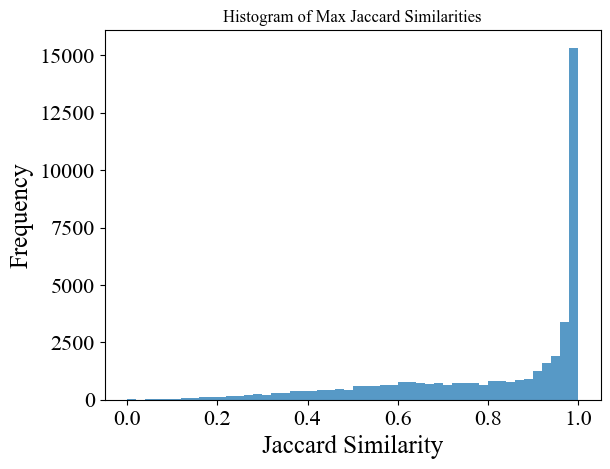

In [27]:
def collect_similarity_scores(data_dict):
    doc_to_text_indices = {}
    max_similarities = []  # List to store maximum similarity scores for plotting

    for doc_id, pages in tqdm(list(data_dict.items())):
        doc_to_text_indices[doc_id] = []
        for page_index, content in pages.items():
            if page_index in ['title', 'doc_long_id']:
                continue

            refined_regions = content['refined_regions']
            segments_or_blocks = []

            if USE_GRAPHSEG:
                segments_or_blocks = graphseg_data[doc_id][page_index]
            else:
                segments_or_blocks = [block['text'] for block in content['blocks']]

            for region in refined_regions:
                if not segments_or_blocks:
                    continue
                # Compute max similarity for each region against all blocks
                max_similarity = max(jaccard_similarity(segment, region['text']) for segment in segments_or_blocks)
                max_similarities.append(max_similarity) 

    return max_similarities


max_similarities = collect_similarity_scores(data_dict)

plt.hist(max_similarities, bins=50, alpha=0.75)
plt.title('Histogram of Max Jaccard Similarities')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.show()

In [28]:
import pandas as pd
import numpy as np

# Save as CSV
df = pd.DataFrame(max_similarities)
df.to_csv(f'Evaluation/{"graphseg" if USE_GRAPHSEG else "block"}_baseline_model_max_similarities.csv', index=False)

#### Elbow Method to Determine Threshold

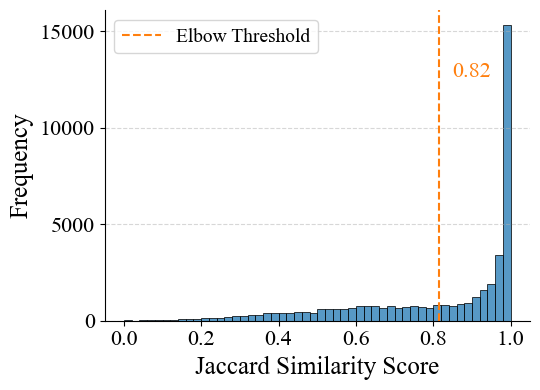

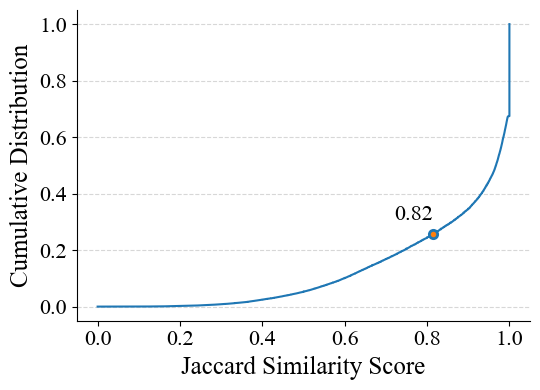

0.8155339805825242

In [29]:
from kneed import KneeLocator
import seaborn as sns

# Load scores data
file_path = f'Evaluation/{"graphseg" if USE_GRAPHSEG else "block"}_baseline_model_max_similarities.csv'
similarities = pd.read_csv(file_path)

if similarities.shape[1] > 1:
    similarities = similarities.iloc[:, 0]
else:
    similarities = similarities.squeeze()  # Convert DataFrame to Series if only one column

# Sort data
sorted_similarities = np.sort(similarities)

# Calculate cumulative distribution
cumulative_distribution = np.cumsum(sorted_similarities) / np.sum(sorted_similarities)

# Find "elbow" in curve
kneedle = KneeLocator(np.arange(len(cumulative_distribution)), cumulative_distribution, S=1.0, curve='convex', direction='increasing')

# map back to actual similarity score
elbow_threshold = sorted_similarities[kneedle.knee]

# Generate plots:
color_palette = sns.color_palette("tab10")
sns.set_palette(color_palette)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_palette)

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'text.color': 'black'
})

# Plot histogram with elbow threshold line
fig, ax = plt.subplots(figsize=(5.5, 4))
bars = ax.hist(sorted_similarities, bins=50, alpha=0.75, color=color_palette[0], edgecolor='black', linewidth=0.7)
ax.set_xlabel('Jaccard Similarity Score', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.axvline(x=elbow_threshold, color=color_palette[1], linestyle='--', linewidth=1.5, label='Elbow Threshold')
ax.text(elbow_threshold * 1.04, ax.get_ylim()[1] * 0.8, f'{elbow_threshold:.2f}', color=color_palette[1], fontsize=16, ha='left', va='center', backgroundcolor='white')
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(f'plots/{"graphseg" if USE_GRAPHSEG else "blocks"}_max_jaccard_similarity_histogram.pdf', pad_inches=0, bbox_inches='tight', dpi=300)
plt.show()

# Plot cumulative distribution with elbow point
fig, ax = plt.subplots(figsize=(5.5, 4)) 
ax.plot(sorted_similarities, cumulative_distribution, color=color_palette[0], marker='o', markevery=[kneedle.knee], markerfacecolor=color_palette[1], markeredgewidth=2)
ax.set_xlabel('Jaccard Similarity Score', fontsize=18)
ax.set_ylabel('Cumulative Distribution', fontsize=18)
ax.grid(True, axis="y", linestyle='--', alpha=0.5)
ax.text(elbow_threshold, cumulative_distribution[kneedle.knee] + 0.05, f'{elbow_threshold:.2f}', color='black', fontsize=16, ha='right')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(f'plots/{"graphseg" if USE_GRAPHSEG else "blocks"}_jaccard_similarity_cumulative_distribution.pdf', pad_inches=0, bbox_inches='tight', dpi=300)
plt.show()

elbow_threshold

### Create Dataset

In [15]:
if PREPROCESS:
    print(f'Preprocessing started. Using {"graphseg segments" if USE_GRAPHSEG else "blocks"} as basis.')
    doc_to_text_indices = {}
    texts = []
    labels = []
    current_index = 0
    threshold = elbow_threshold # pull from above
    print(f"Using threshold: {threshold}")

    for doc_id, pages in tqdm(list(data_dict.items())[:DATA_SIZE]):
        doc_to_text_indices[doc_id] = []
        for page_index, content in pages.items():
            if page_index in ['title', 'doc_long_id']:
                continue
            refined_regions = content['refined_regions']

            segments_or_blocks = []
            if USE_GRAPHSEG:
                segments_or_blocks = graphseg_data[doc_id][page_index]
            else:
                segments_or_blocks = [block['text'] for block in content['blocks']]

            for segment in segments_or_blocks:
                # Determine if the segment/block matches any refined region
                # Leverage the defined threshold to determine a match
                match = any(jaccard_similarity(segment, region['text']) > threshold for region in refined_regions)
                texts.append(segment)
                labels.append(1 if match else 0)
                doc_to_text_indices[doc_id].append(current_index)
                current_index += 1

    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    full_dataset = TextDataset(encodings, labels)

    # Load document splits from JSON file
    with open(SPLITS_JSON, 'r') as f:
        document_splits = json.load(f)
    
    train_doc_ids = document_splits['train_ids']
    val_doc_ids = document_splits['val_ids']
    test_doc_ids = document_splits['test_ids']

    # Function to create subsets of TextDataset
    def create_subset(dataset, doc_ids, doc_to_text_indices):
        indices = [idx for doc_id in doc_ids for idx in doc_to_text_indices[doc_id]]
        return Subset(dataset, indices)

    # Create subset
    train_dataset = create_subset(full_dataset, train_doc_ids, doc_to_text_indices)
    val_dataset = create_subset(full_dataset, val_doc_ids, doc_to_text_indices)
    test_dataset = create_subset(full_dataset, test_doc_ids, doc_to_text_indices)

    # Helper function to add documents to new data_dict based on indices
    def add_to_split_dict(split_dict, original_dict, doc_ids):
        for doc_id in doc_ids:
            split_dict[doc_id] = original_dict[doc_id]

    # Initialize split dictionaries
    train_data_dict = defaultdict(lambda: defaultdict(default_page))
    val_data_dict = defaultdict(lambda: defaultdict(default_page))
    test_data_dict = defaultdict(lambda: defaultdict(default_page))

    # Split data_dict into train, val, and test dicts
    add_to_split_dict(train_data_dict, data_dict, train_doc_ids)
    add_to_split_dict(val_data_dict, data_dict, val_doc_ids)
    add_to_split_dict(test_data_dict, data_dict, test_doc_ids)

Preprocessing started. Using blocks as basis.
Using threshold: 0.8155339805825242


  0%|          | 0/1149 [00:00<?, ?it/s]

In [6]:
folder = f'{DATA_PATH}/Model/datasets/{"graphseg" if USE_GRAPHSEG else "blocks"}'

In [7]:
if PREPROCESS:
    # Save data for future use:
    print("Saving datasets.")
    torch.save(train_dataset, f'{folder}/train_dataset.pth')
    torch.save(val_dataset, f'{folder}/val_dataset.pth')
    torch.save(test_dataset, f'{folder}/test_dataset.pth')

    # Save doc_to_text_indices and split dicts
    with open(f'{folder}/doc_to_text_indices.pkl', 'wb') as f:
        pickle.dump(doc_to_text_indices, f)

    print("Saving datadicts.")
    with open(f'{folder}/train_data_dict.pkl', 'wb') as f:
        pickle.dump(dict(train_data_dict), f)

    with open(f'{folder}/val_data_dict.pkl', 'wb') as f:
        pickle.dump(dict(val_data_dict), f)

    with open(f'{folder}/test_data_dict.pkl', 'wb') as f:
        pickle.dump(dict(test_data_dict), f)
else:
    # Load datasets
    print("Loading datasets.")
    train_dataset = torch.load(f'{folder}/train_dataset.pth')
    val_dataset = torch.load(f'{folder}/val_dataset.pth')
    test_dataset = torch.load(f'{folder}/test_dataset.pth')

    # Load doc_to_text_indices and split dicts
    with open(f'{folder}/doc_to_text_indices.pkl', 'rb') as f:
        doc_to_text_indices = pickle.load(f)

    print("Loading datadicts.")
    with open(f'{folder}/train_data_dict.pkl', 'rb') as f:
        train_data_dict = pickle.load(f)

    with open(f'{folder}/val_data_dict.pkl', 'rb') as f:
        val_data_dict = pickle.load(f)

    with open(f'{folder}/test_data_dict.pkl', 'rb') as f:
        test_data_dict = pickle.load(f)

Loading datasets.
Loading datadicts.


### Setup prediction model based on datasets/segments define above

Leveraging AutoModelForSequenceClassification from HF

In [18]:
# Check if saved checkpoint exists
latest_checkpoint = None
if CHECKPOINT:
    checkpoint_directory = f'{DATA_PATH}/{CHECKPOINT}'
    if os.path.exists(checkpoint_directory):
        latest_checkpoint = checkpoint_directory

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

training_args = TrainingArguments(
    output_dir=f'{DATA_PATH}/Model/results/{unique_tag}',
    num_train_epochs= EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'{DATA_PATH}/Model/logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    greater_is_better=False, 
    report_to="wandb",
    fp16=True
)

# Create Trainer instance with EarlyStoppingCallback
trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience= 3)]
)

trainer.train(resume_from_checkpoint=latest_checkpoint)

# Save model
model_save_path = f"{DATA_PATH}/Model/results/saved_model/{unique_tag}"
os.makedirs(model_save_path, exist_ok=True)
trainer.save_model(model_save_path)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.234800,0.240936
2,0.203600,0.215634
3,0.161700,0.227869


### Evaluate

In [16]:
# Evaluate on the test set
test_results = trainer.evaluate(test_dataset)
print("Test Set Evaluation Results:")
for key, value in test_results.items():
    print(f"{key}: {value}")

Test Set Evaluation Results:
eval_loss: 0.24191118776798248
eval_runtime: 38.1144
eval_samples_per_second: 545.7
eval_steps_per_second: 4.277
epoch: 3.0


In [17]:
wandb.finish()

eval/loss,█▂▄▁
eval/runtime,▂▁▁█
eval/samples_per_second,▁███
eval/steps_per_second,▁██▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/learning_rate,▂▂▃▄▄▅▆▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
train/loss,█▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


### Read Pretrained Model for Evaluation

In [8]:
if PRETRAINED_MODEL:
    model = AutoModelForSequenceClassification.from_pretrained(f"{DATA_PATH}/Model/results/saved_model/{PRETRAINED_MODEL}")
    model.to('cuda')
    model.eval()
    print(f"Model {PRETRAINED_MODEL} successfully loaded.")

Model 4wvN23 successfully loaded.


In [7]:
def predict_block(block_text):
    '''
    Predicts class of a given block of text
    '''
    inputs = tokenizer(block_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    return probs[0, predicted_class].item(), predicted_class

# Example text extracted from data_dict
block_text = """
Authorizing Certain Transactions Involving the Exportation or Reexportation of
Liquefied Petroleum Gas to Venezuela
(a) Except as provided in paragraph (b) of this general license, all transactions 
related to the exportation or reexportation, directly or indirectly, of liquefied petroleum 
gas to Venezuela, involving the Government of Venezuela, Petróleos de Venezuela, S.A. 
(PdVSA), or any entity in which PdVSA owns, directly or indirectly, a 50 percent or 
greater interest, that are prohibited by E.O. 13850 of November 1, 2018, as amended by 
E.O. 13857 of January 25, 2019, or E.O. 13884 of August 5, 2019, each as incorporated 
into the Venezuela Sanctions Regulations, 31 CFR part 591 (the VSR), are authorized 
through 12:01 a.m. eastern daylight time, July 10, 2024.
(b) This general license does not authorize:
(1) Any payment-in-kind of petroleum or petroleum products; or
(2) Any transactions otherwise prohibited by the VSR, including transactions 
involving any blocked persons other than PdVSA, any entity in which PdVSA owns, 
directly or indirectly, a 50 percent or greater interest, or any Government of Venezuela 
person that is blocked solely pursuant to E.O. 13884.
"""
probability, predicted_class = predict_block(block_text)
print(f"Predicted class: {predicted_class} (Probability: {probability:.4f})")


Predicted class: 1 (Probability: 0.8602)


#### Example: Get snippets for a document by picking the correct blocks

In [13]:
def get_regions_for_doc(doc_id, page_index):
    regions = []
    for idx, block in enumerate(data_dict[doc_id][page_index]['blocks']):
        probability, predicted_class = predict_block(block['text'])
        print(f"Block {idx}: Class={predicted_class} ({round(probability*100, 2)}%)")
        if predicted_class == 1:
            regions.append((block['text'], probability))
    return regions

doc_id = '19236880'
page_index = '34'
regions = get_regions_for_doc(doc_id, page_index)

for region in regions:
    print(region)

## Run Model on Test data and collect predictions in data_dict

In [9]:
import evaluator
import importlib
importlib.reload(evaluator)
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)
model.eval()

# Add snippets to data_dict
def predict_batch(text_blocks, batch_size=BATCH_SIZE):
    predictions = []
    for i in range(0, len(text_blocks), batch_size):
        batch = text_blocks[i:i+batch_size]

        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_classes = torch.argmax(probs, dim=1)
        for prob, predicted_class in zip(probs, predicted_classes):
            predictions.append((prob[predicted_class].item(), predicted_class.item()))

    return predictions

# Choose data_dict to process
dict_to_process = test_data_dict # (for aml: test_data_dict, else data_dict)

total_time = 0
for doc_id, pages in tqdm(dict_to_process.items()):
    for page_index, page_data in pages.items():
        if page_index in ['title', 'doc_long_id']:
            continue
        segments_or_blocks = []
        if USE_GRAPHSEG:
            segments_or_blocks = graphseg_data[doc_id][page_index]
        else:
            segments_or_blocks = [block['text'] for block in page_data['blocks']]

        dict_to_process[doc_id][page_index]['predicted_snippets'] = []

        # Get predictions for all text blocks in the current page
        start_time = time.time()
        batch_predictions = predict_batch(segments_or_blocks, 512)
        end_time = time.time()
        total_time += end_time - start_time

        for segment_or_block, (probability, predicted_class) in zip(segments_or_blocks, batch_predictions):
            if predicted_class == 1:
                dict_to_process[doc_id][page_index]['predicted_snippets'].append({'text': segment_or_block, 'tokenized_text': tokenizer.tokenize(segment_or_block), 'probability': probability})
print(f"Total time taken: {total_time:.2f} seconds")

Using device: cuda


  0%|          | 0/173 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors


Total time taken: 140.17 seconds


In [10]:
# Get page count
page_count = 0
for doc_id, pages in tqdm(dict_to_process.items()):
    for page_index, page_data in pages.items():
        if page_index in ['title', 'doc_long_id']:
            continue
        page_count += 1

  0%|          | 0/173 [00:00<?, ?it/s]

### Get evaluation metrics 

In [11]:
import evaluator
import importlib
importlib.reload(evaluator)

<module 'evaluator' from '/home/tlh45/project/code/Model/evaluator.py'>

In [14]:
metrics_config = {
    'iou': True,
    'bleu': True,
    'jaccard': True,
    'precision': True,
    'recall': True,
    'f1': True,
    'precision_region_lvl': True,
    'recall_region_lvl': True,
    'f1_region_lvl': True,
    'edit_distance': True,
    'rouge-1-f': True,
    'rouge-2-f': True,
    'rouge-l-f': True,
    'pk': False,
    'windowdiff': False,
    'cohen_kappa': False
}

print(f"{DOMAIN=}")
BASE = False

# Base allows evaluation of basic components (i.e. perfect blocks and snippets) against regions
if BASE:
    print("################### PERFECT BLOCKS ###################")
    aggregated_metrics_perfectblocks = evaluator.evaluate_snippets_parallel(dict_to_process
                                        ,comparison_object="blocks"
                                        , config=metrics_config)
    print("################### SNIPPETS ###################")
    aggregated_metrics_snippets = evaluator.evaluate_snippets_parallel(dict_to_process
                                        ,comparison_object="snippets"
                                        , config=metrics_config)


    
print(f'################### PREDICTED {"GRAPHSEG SEGMENTS" if USE_GRAPHSEG else "BLOCKS"} ###################')
aggregated_metrics_predicted_snippets = evaluator.evaluate_snippets_parallel(dict_to_process
                                     ,comparison_object="predicted_snippets"
                                     , config=metrics_config)
aggregated_metrics_predicted_snippets['inference_time'] = total_time + 805.1935110092163 if USE_GRAPHSEG else total_time # add time for graphseg
aggregated_metrics_predicted_snippets['pages'] = page_count
aggregated_metrics_predicted_snippets['batch_size'] = BATCH_SIZE
aggregated_metrics_predicted_snippets['GPU'] = torch.cuda.get_device_properties(0).name

DOMAIN='AML'
################### PREDICTED GRAPHSEG SEGMENTS ###################


In [15]:
# Save evaluation results
if BASE:
    with open(f"Evaluation/{DOMAIN}/perfectblocks_eval_final.json", 'w') as f:
        json.dump(aggregated_metrics_perfectblocks, f, indent=4)

    with open(f"Evaluation/{DOMAIN}/snippets_eval_final.json", 'w') as f:
        json.dump(aggregated_metrics_snippets, f, indent=4)

with open(f"Evaluation/{DOMAIN}/{'graphseg' if USE_GRAPHSEG else 'blocks'}_eval_final_{PRETRAINED_MODEL}.json", 'w') as f:
    json.dump(aggregated_metrics_predicted_snippets, f, indent=4)

#### Collect time it takes to create snippets

In [27]:
from Snippet_Code import node_utils # import snippeting algorith here (not included here due to confidentiality)
snippets_time = 0
for doc_id, pages in tqdm(dict_to_process.items()):
    for page_index, page_data in pages.items():
        if page_index in ['title', 'doc_long_id']:
            continue
        full_page_text = page_data['full_text']
        start_time = time.time()
        snippets, snippet_character_type = node_utils.split_page_into_snippets(full_page_text, page_index)
        end_time = time.time()
        snippets_time += end_time - start_time
print(snippets_time)

  0%|          | 0/173 [00:00<?, ?it/s]

In [28]:
print(f"Total time taken: {snippets_time} seconds")

Total time taken: 172.6988410949707 seconds
